# **CFAR**

Constant False Alarm Rate (CFAR) is used to compute a dynamic threshold to make detections in noisy data. In this notebook we will learn about the most simple form, which is Cell Averaging CFAR or CA-CFAR.

refs:
- https://engineering.purdue.edu/~mrb/resources/AltLectureF/Session_21.pdf
- https://www.mathworks.com/help/phased/ug/constant-false-alarm-rate-cfar-detection.html
- https://apps.dtic.mil/sti/pdfs/ADA429631.pdf

## Background

We are working on a Detection problem where we are aiming to detect a signal in the noise. We can make two simple hypotheses to formally describe the problem:

$$
    H_0 \rightarrow \quad \text{ No signal present } 
    \\
    H_1 \rightarrow \quad \text{ Signal present }
$$

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *
from radar.range_processing import *
from radar.doppler_processing import *
from radar.azimuth_processing import *

%matplotlib inline

### CFAR Examples

In [464]:
# get noisy signal
x = np.zeros((400))
x +=  np.random.normal(0, 1, 400)

# add sources to the noise
sources = np.random.choice(np.arange(0, 400), 10, replace=False)
x[sources] += 5

# spread the sources to simulate range spread
x[sources - 1] += 3
x[sources + 1] += 3
x[sources - 2] += 2
x[sources + 2] += 2
x[sources - 3] += 1
x[sources + 3] += 1


x -= x.min()

thresh = 6
detected = x > thresh

In [465]:
np.sort(sources), np.sort(np.where(detected == 1))

(array([ 20,  88, 104, 170, 212, 232, 257, 304, 314, 320]),
 array([[ 20,  87,  88, 104, 105, 169, 170, 171, 212, 231, 232, 233, 257,
         304, 305, 315, 320, 321]]))

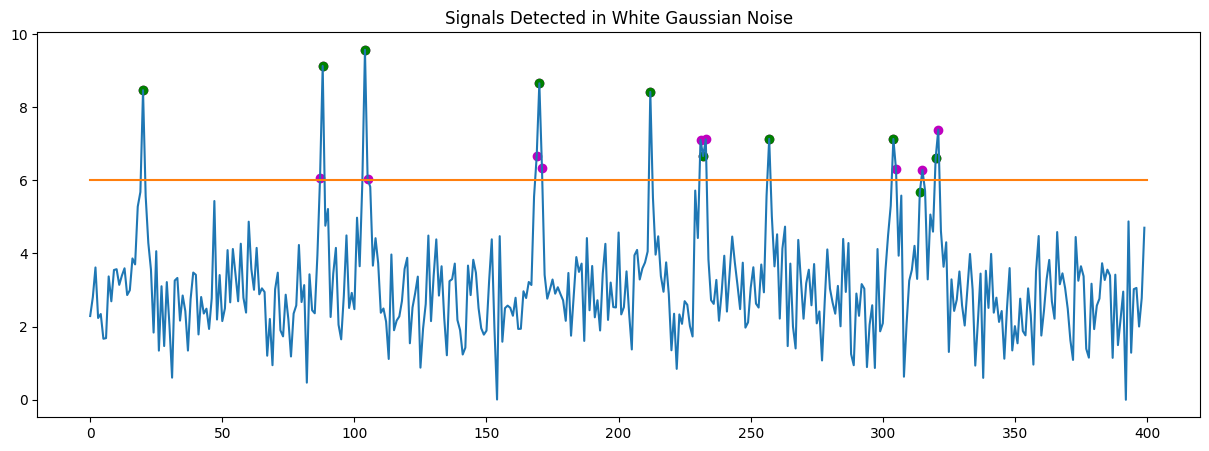

In [466]:
plt.figure(figsize=(15,5))
plt.plot(x)
plt.plot([0, 400], [thresh, thresh])
plt.scatter(np.where(detected == 1), x[detected], c='m');
plt.scatter(sources, x[sources], c='g');
plt.title("Signals Detected in White Gaussian Noise");

### Non-Stationary noise

In [467]:
# generate non-stationary noise
n2 = np.random.normal(0, 1, 400) + 2*np.sin(np.arange(0, 400)/50)
x2 = x + n2

In [468]:
detected_2 = x2 > thresh

In [469]:
np.sort(sources), np.sort(np.where(detected_2 == 1))

(array([ 20,  88, 104, 170, 212, 232, 257, 304, 314, 320]),
 array([[ 18,  19,  20,  22,  23,  47,  52,  54,  58,  60,  65,  77,  87,
          88,  89,  90,  97, 101, 103, 104, 105, 106, 170, 171, 212, 257,
         304, 312, 314, 316, 320, 321, 322, 359, 366, 375, 384, 385, 388,
         395]]))

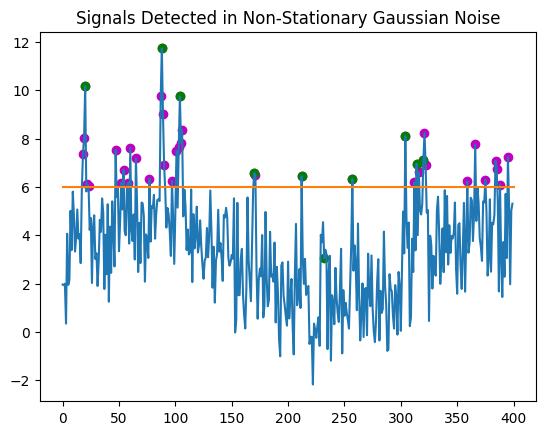

In [470]:
plt.plot(x2);
plt.plot([0, 400], [thresh, thresh])
plt.scatter(np.where(detected_2 == 1), x2[detected_2], c='m');
plt.scatter(sources, x2[sources], c='g');
plt.title("Signals Detected in Non-Stationary Gaussian Noise");

### Moving Average Threshold

In [471]:
from scipy.ndimage import convolve1d

# get moving average
win_sz = 25
win = np.ones(win_sz)/win_sz
ma = convolve1d(x2, win, mode='nearest')

# get new threshold from moving average
threshold_ma = 3 + ma

# get new detections
detected_3 = x2 > threshold_ma

In [472]:
np.sort(sources), np.sort(np.where(detected_3 == 1))

(array([ 20,  88, 104, 170, 212, 232, 257, 304, 314, 320]),
 array([[ 19,  20,  47,  87,  88,  89, 104, 106, 169, 170, 171, 212, 231,
         257, 304, 321, 366]]))

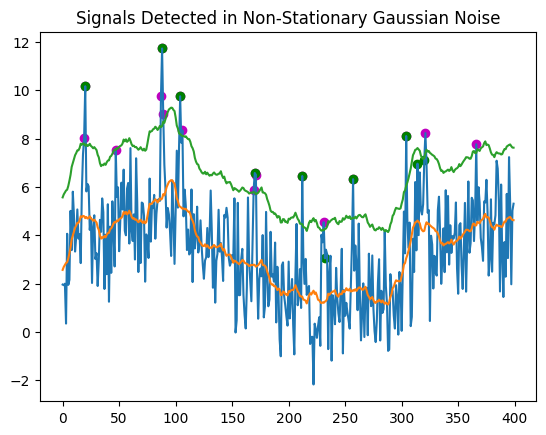

In [473]:
plt.plot(x2);
plt.plot(ma);
plt.plot(threshold_ma);
plt.scatter(np.where(detected_3 == 1), x2[detected_3], c='m');
plt.scatter(sources, x2[sources], c='g');
plt.title("Signals Detected in Non-Stationary Gaussian Noise");

### Implement Cell Averaging CFAR

In [538]:
gaurd_len = 0
train_len = 10

In [539]:
cfar_kernel = np.ones((1 + 2*gaurd_len + 2*train_len), dtype=float) / (2*train_len)
cfar_kernel[train_len: train_len + (2*gaurd_len) + 1] = 0.

# get gaurd and cell under test for viz
gaurd_cells = np.zeros_like(cfar_kernel)
gaurd_cells[train_len: train_len + (2*gaurd_len) + 1] = cfar_kernel[0]
gaurd_cells[len(gaurd_cells)//2] = 0.

cut = np.zeros_like(cfar_kernel)
cut[len(gaurd_cells)//2] = cfar_kernel[0]

In [560]:
p_fa = 0.1 # Probability of False Alarm


a = train_len*(p_fa**(-1/train_len) - 1)
print(f"Threshold scale factor: {a}");

Threshold scale factor: 2.589254117941673


In [561]:
from scipy.ndimage import convolve1d

noise_level = convolve1d(x2, cfar_kernel, mode='nearest')
threshold = (noise_level + 1) * (a - 1)

In [562]:
# get new detections
detected_4 = x2 > threshold

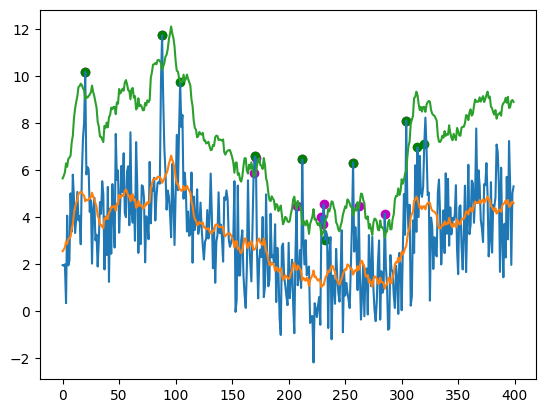

In [563]:
plt.plot(x2)
plt.plot(noise_level)
plt.plot(threshold)
plt.scatter(np.where(detected_4 == 1), x2[detected_4], c='m');
plt.scatter(sources, x2[sources], c='g');

In [771]:
np.sort(sources), np.sort(np.where(detected_4 == 1))

(array([107, 126, 170, 174, 197, 224, 274, 302, 312, 327]),
 array([[ 16, 107, 170, 174, 185, 197, 214, 224, 233, 236, 239, 251, 274,
         284, 302, 312]]))

CFAR is not perfect in this case, the moving average is much better, so why even use CFAR? The short answer is because it works and there has been much research into different variations of CFAR the each have their own pros and cons. It turns out that it's very difficult to realistically model Radar clutter and noise, so we will use real FMCW Radar data to run an example of CFAR.

### CFAR on Real Data

In [564]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [565]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:
    for key in h5_obj.keys():
        data_dict.update({key : np.asarray(h5_obj[key])})

In [566]:
data_idx = 21

In [567]:
adc_data = data_dict['radar'][data_idx, ...]

In [568]:
rgb_image = data_dict['rgb'][data_idx, ...]
depth = data_dict['depth'][data_idx, ...]

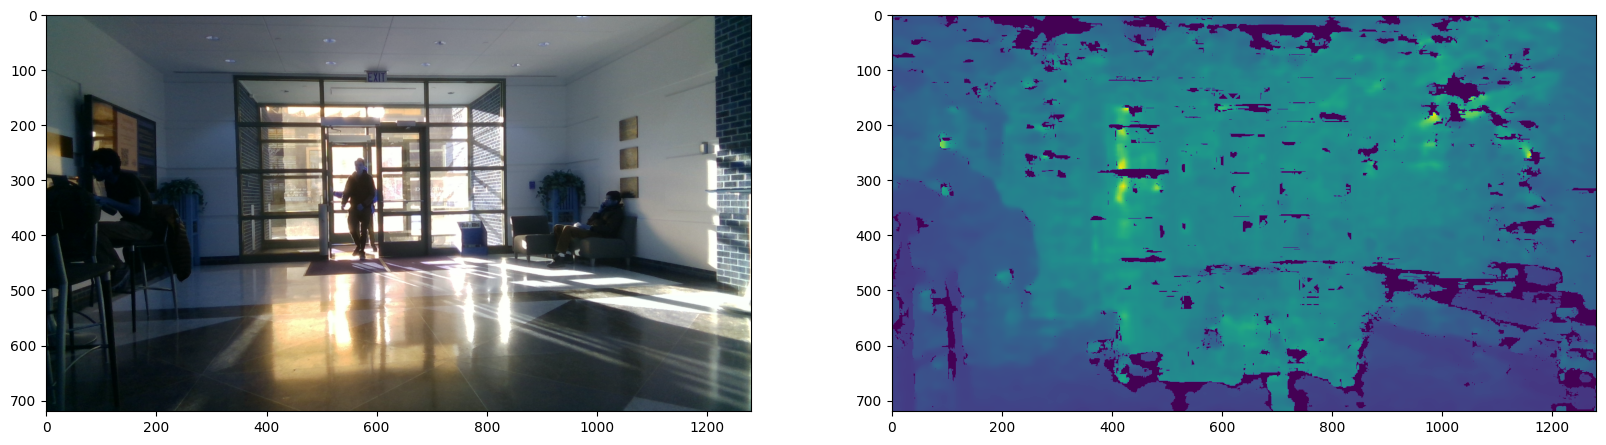

In [569]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(rgb_image)
ax[1].imshow(depth);

## Process Data

In [570]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

# perform azimuth processing
steering_vector = compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90)
range_azimuth = capon_spectrum(range_doppler, steering_vector)

## Implement CA-CFAR

Implement Cell Averaging CFAR to detect the targets

For this excercise, the signal of interest will be the range aggregated across all Doppler Bins

In [571]:
x = np.abs(range_doppler).sum(axis=1).sum(axis=1) / (range_doppler.size)

# 'notch' the clutter bins
x[:10] = np.median(x[10:]) # - x[10:20].std()

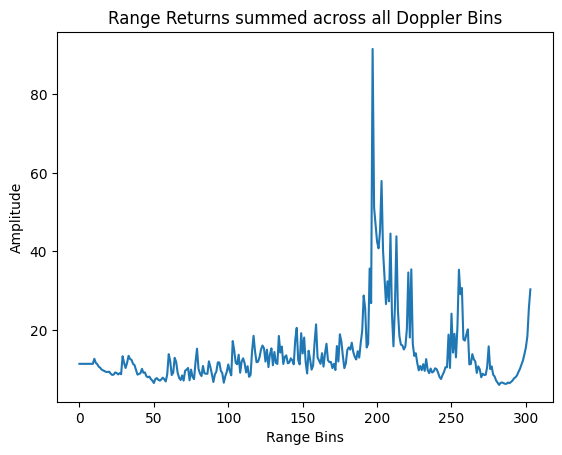

In [572]:
plt.plot(x);
plt.title("Range Returns summed across all Doppler Bins")
plt.xlabel("Range Bins");
plt.ylabel("Amplitude");

#### Compute Power Spectral Density

In [573]:
range_doppler_psd = 10*np.log10( np.abs(range_doppler) ).sum(axis=1).T

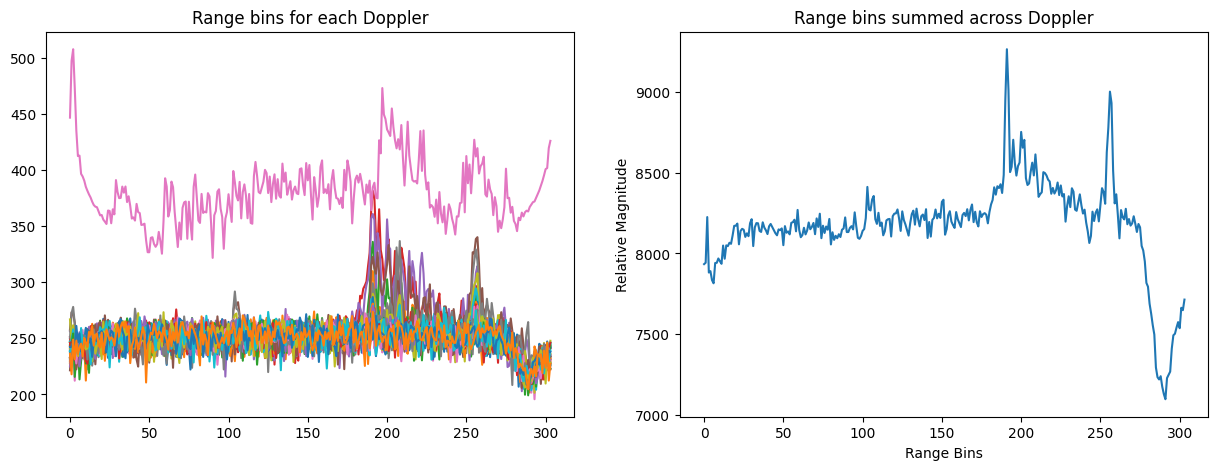

In [574]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range_doppler_psd.T); # plot range hits from each Doppler Bin
ax[0].set_title("Range bins for each Doppler")
ax[1].set_xlabel("Range Bins")
ax[1].set_ylabel("Relative Magnitude");
ax[1].plot(range_doppler_psd.sum(axis=0)); # Sum Range hits across Doppler Bins
ax[1].set_title("Range bins summed across Doppler")
ax[1].set_xlabel("Range Bins")
ax[1].set_ylabel("Relative Magnitude");

## Get a 1D signal

For this excercise we will aggregate all the Doppler Bins into a single Range return, normally, we wopuld process the Range returns individually for each Doppler Bin.


The reason why the clutter returns are lower in the log signal is because the relative dB power of the returns around 200 for nearly all the range bins adds up to a large value compared to the clutter return that only has a peak in the 0 Doppler bin.

For the amplitude signal, the first few range bins usually have erroneously high returns due to ground clutter, so we will set them to a lower value governed by the median of the remaining value.

In [575]:
# signal of interest

# amplitude signal
x = np.abs(range_doppler).sum(axis=1).sum(axis=1) / (range_doppler.size)
x[:10] = np.median(x[10:]) # 'notch' the clutter bins

# log signal
x = range_doppler_psd.sum(axis=0) 
x /= x.size # normalize to reduce dynamic range

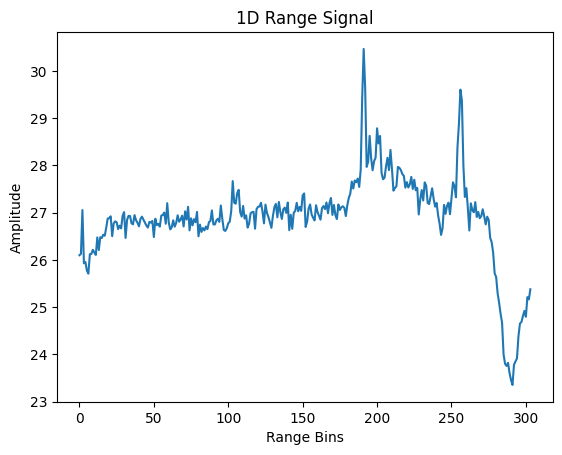

In [576]:
plt.plot(x);
plt.xlabel("Range Bins")
plt.ylabel("Amplitude");
plt.title("1D Range Signal");

Set CFAR parameters

In [577]:
gaurd_len = 3
train_len = 12

# gaurd_len = 2
# train_len = 12

create CFAR kernel to efficiently estimate noise

In [578]:
cfar_kernel = np.ones((1 + 2*gaurd_len + 2*train_len), dtype=float) / (2*train_len)
cfar_kernel[train_len: train_len + (2*gaurd_len) + 1] = 0.

# get gaurd and cell under test for viz
gaurd_cells = np.zeros_like(cfar_kernel)
gaurd_cells[train_len: train_len + (2*gaurd_len) + 1] = cfar_kernel[0]
gaurd_cells[len(gaurd_cells)//2] = 0.

cut = np.zeros_like(cfar_kernel)
cut[len(gaurd_cells)//2] = cfar_kernel[0]

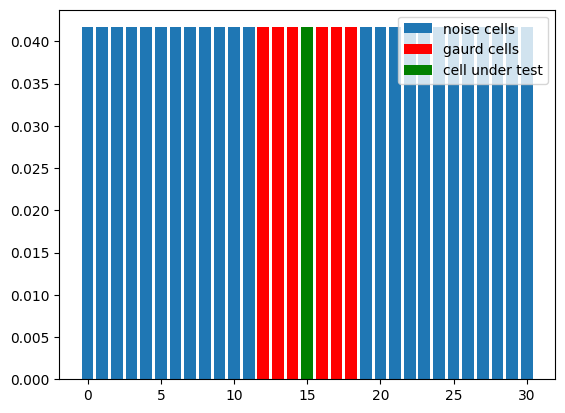

In [579]:
plt.bar(np.arange(len(cfar_kernel)), cfar_kernel, label="noise cells");
plt.bar(np.arange(len(cfar_kernel)), gaurd_cells, color='r', label='gaurd cells');
plt.bar(np.arange(len(cfar_kernel)), cut, color='g', label='cell under test');
plt.legend();

Detection threshold parameter

https://www.mathworks.com/help/phased/ug/constant-false-alarm-rate-cfar-detection.html

In [580]:
# p_fa = 0.15 # Probability of False Alarm
p_fa = 0.05 # Probability of False Alarm

a = train_len*(p_fa**(-1/train_len) - 1)
print(f"Threshold scale factor: {a}");

Threshold scale factor: 3.4028261053501945


In [581]:
# a = p_fa**(-1/train_len) - 1

Compute Noise Level and Threshold

In [582]:
from scipy.ndimage import convolve1d

noise_level = convolve1d(x, cfar_kernel, mode='nearest')

# amplitude threshold
threshold = noise_level * a

# log threshold
threshold = noise_level + np.log(a)

In [583]:
detected = x > threshold

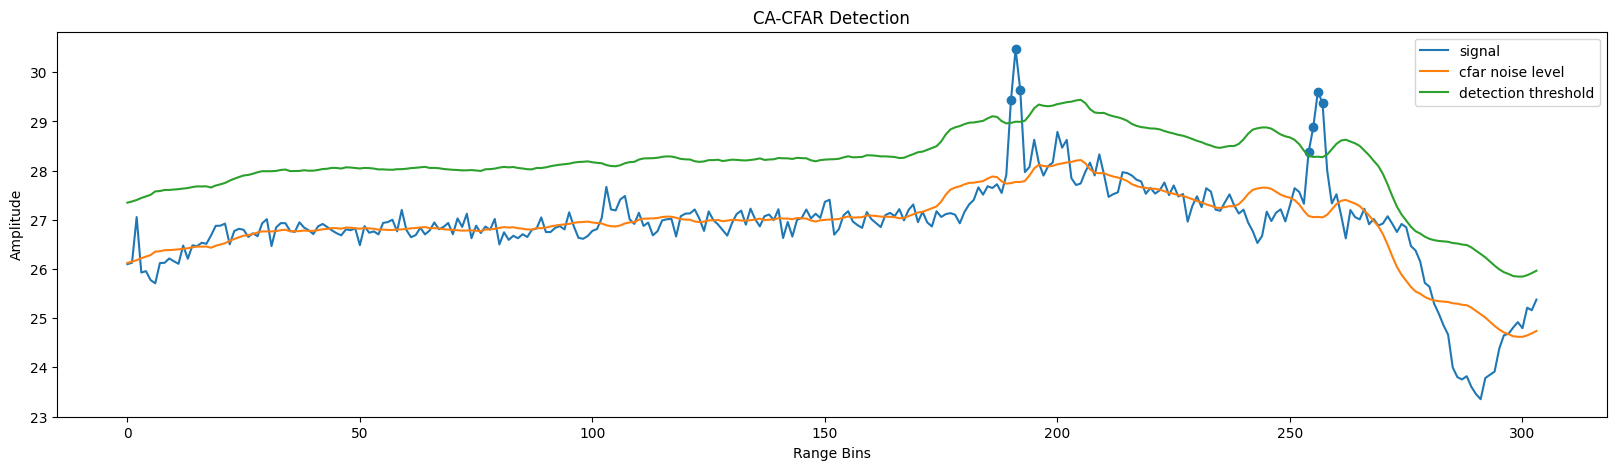

In [584]:
plt.figure(figsize=(20, 5))
plt.plot(x, label='signal')
plt.plot(noise_level, label='cfar noise level')
plt.plot(threshold, label='detection threshold')

# display detected targets
plt.scatter(np.arange(0, len(noise_level))[detected], x[detected])

plt.title("CA-CFAR Detection")
plt.xlabel("Range Bins")
plt.ylabel("Amplitude");

plt.legend();

Notice how the detection threshold is lowered around the peaks, this is the benefit of using gaurd cells. It allows us to account for range spread that can throw off our noise estimates.